# Dependencies and Data Import
Imports for plotting:

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib notebook

mpl.rc('figure', figsize=(10, 5))
mpl.rc('image', cmap='gray')

Imports for scientific Python libs:

In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series

import pims
import trackpy as tp

from roipoly import RoiPoly

## Import data

In [3]:
frames = pims.ImageSequence("../test/k255e_pos3_mag_tif_invert/*.tif", as_grey=True)

In [4]:
frames

<Frames>
Source: /Users/johanan/prog/test/k255e_pos3_mag_tif_invert/*.tif
Length: 839 frames
Frame Shape: (403, 438)
Pixel Datatype: uint16

In [5]:
print(frames[0]) # first frame

[[5778 5443 5531 ... 5913 6021 6058]
 [5815 5619 5637 ... 5995 5918 5919]
 [5646 5518 5479 ... 6190 5987 5889]
 ...
 [5467 5476 5589 ... 5909 5889 5677]
 [5291 5306 5477 ... 5891 5970 5900]
 [5427 5293 5307 ... 5853 5908 5978]]


/Users/johanan/prog/magtrack/venv/lib/python3.7/site-packages/jinja2/utils.py:485: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping


Frame([[5778, 5443, 5531, ..., 5913, 6021, 6058],
       [5815, 5619, 5637, ..., 5995, 5918, 5919],
       [5646, 5518, 5479, ..., 6190, 5987, 5889],
       ...,
       [5467, 5476, 5589, ..., 5909, 5889, 5677],
       [5291, 5306, 5477, ..., 5891, 5970, 5900],
       [5427, 5293, 5307, ..., 5853, 5908, 5978]], dtype=uint16)
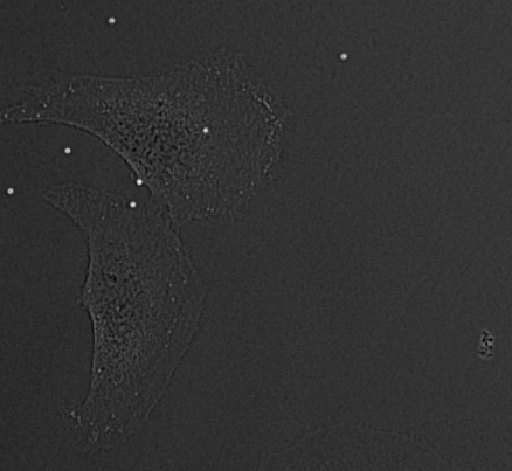

In [6]:
frames[0]

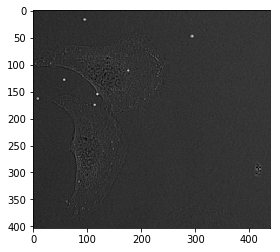

In [7]:
plt.imshow(frames[0])
immobile_bead = RoiPoly(color='b')

In [ ]:
plt.imshow(frames[0])
immobile_bead.display_roi()
mask = immobile_bead.get_mask(frames[0])
plt.imshow(mask)

In [ ]:
frames[123].frame_no

In [ ]:
frames[123].metadata

# Locate Features
Start with first frame, estimate feature size in px. **Size must be an odd integer and it's ok to overestimate.**

Filter by brightness (`minmass`), with 20 iterations per frame to locate objects.

In [ ]:
f = tp.locate(frames[0], 11, minmass=49000, max_iterations=20)

Returns DataFrame that's basically a matrix object with row and column labels. We can view the first few rows with `f.head()`:

In [ ]:
f.head()

`locate` lists each feature's:
* position
* characteristics of appearance (which are useful for filtering spurious features)
* signal strength & uncertainty estimate

We can view which features were found:

In [ ]:
plt.figure()
tp.annotate(f, frames[0]);

We should examine subpixel accuracy to see if the decimal part of x and y positions are biased using `subpx_bias`.

In [ ]:
tp.subpx_bias(f)
plt.show()

Let's see how different mask sizes affect subpixel bias:

In [ ]:
for i in range (7,16,2):
    print("Mask size:", i, "px")
    tp.subpx_bias(tp.locate(frames[0], i, minmass=49000, max_iterations=20));
    plt.show()

If subpixel accuracy is good, the histograms should be flat. If it's depressed in the middle, use a larger feature diameter. 9 or 11 px appear to be good diameter estimates, which is what we measured using ImageJ.

## Locate features in all frames

### Frame selection syntax

All frames: `frames[:]` or just `frames`.
First 10 frames: `frames[:10]`
Last 10 frames: `frames[-10:]`
Range of frames: `frames[100:200]`
Every 10th frame: `frame[::10]`
Specific frames: `frames[[100, 107, 113]]`

### Locate in all frames
We use `tp.batch` which calls `tp.locate` on each frame and collects results.

In [ ]:
f = tp.batch(frames, 11, minmass=49000, max_iterations=20);

# Link features into trajectories
We have all the particles in all frames, so now we'll track particles from frame to frame.

First, specify maximum displacement that a particle can travel between frames. Choose smallest reasonable value because a large value increases the search neighbourhood. 5 px should be reasonable.

Second, allow for particle dropout in a few frames. In this case, we'll use a 5-frame memory.

In [ ]:
t = tp.link_df(f, 5, memory=5)

Now we have a new DataFrame `t` which is essentially `f` with an additional column `particle` identifying each feature with a label.

In [ ]:
t.head()

## Filter spurious trajectories
Cut out ephemeral trajectories using `filter_stubs`, which keeps only trajectories that last for a given number of frames. We'll use the length of the time series since we want to track the same particles throughout the sequence.

In [ ]:
t1 = tp.filter_stubs(t,838)
# Compare number of particles in unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())
t1.index.names = ['']
t1

We have 7 trajectories, which matches the number of beads we found in the first frame. Let's trace the trajectories with `plot_traj` to confirm.

In [ ]:
plt.figure()
tp.plot_traj(t1);

Some drift is visible across all trajectories, so let's filter that out with `compute_drift`.

In [ ]:
d = tp.compute_drift(t1)

In [ ]:
d.plot()
plt.show()

Now we can subtract this drift.

In [ ]:
tm = tp.subtract_drift(t1.copy(), d)

We can now plot trajectories again.

In [ ]:
plt.figure()
ax = tp.plot_traj(tm);

# Analyze Trajectories
## MSD of individual beads